In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
DATA_PATH = '../data/vehicle_updates_with_delays.csv'
data_df = pd.read_csv(DATA_PATH)

In [3]:
data_df.head()

,timestamp_utc,vehicle_id,trip_id,route_id,lat,lon,speed,heading,vehicle_timestamp,stop_id,current_stop_sequence,delay_seconds
0,2025-10-16 14:39:27,VehiclePosition-BKK_100,D0477613651,1050,47.517323,19.073917,6.687772,322.0,2025-10-16 14:39:14,F01059,19,674
1,2025-10-16 14:39:27,VehiclePosition-BKK_1002,C91341102,2170,47.483334,19.127817,0.000000,332.0,2025-10-16 14:39:11,NaN,0,0
2,2025-10-16 14:39:27,VehiclePosition-BKK_101,C95520687,2121,47.478680,19.031557,0.000000,162.0,2025-10-16 14:39:01,F02122,16,361
3,2025-10-16 14:39:27,VehiclePosition-BKK_1017,C889321206,0680,47.487255,19.179697,1.543332,280.0,2025-10-16 14:39:10,F01603,7,70
4,2025-10-16 14:39:27,VehiclePosition-BKK_102,D029769537,2210,47.504440,18.998335,10.288880,311.0,2025-10-16 14:39:13,F02391,7,73


In [4]:
data_df['timestamp_utc'] = pd.to_datetime(data_df['timestamp_utc'], errors='coerce')

In [5]:
data_df['hour'] = data_df['timestamp_utc'].dt.hour
data_df['day_of_week'] = data_df['timestamp_utc'].dt.dayofweek 
data_df['is_weekend'] = data_df['day_of_week'] >= 5

In [6]:
features_to_check = ['delay_seconds', 'hour', 'day_of_week', 'is_weekend', 'heading', 'speed', 'lat', 'lon']

In [8]:
corr_matrix = data_df[features_to_check].corr()

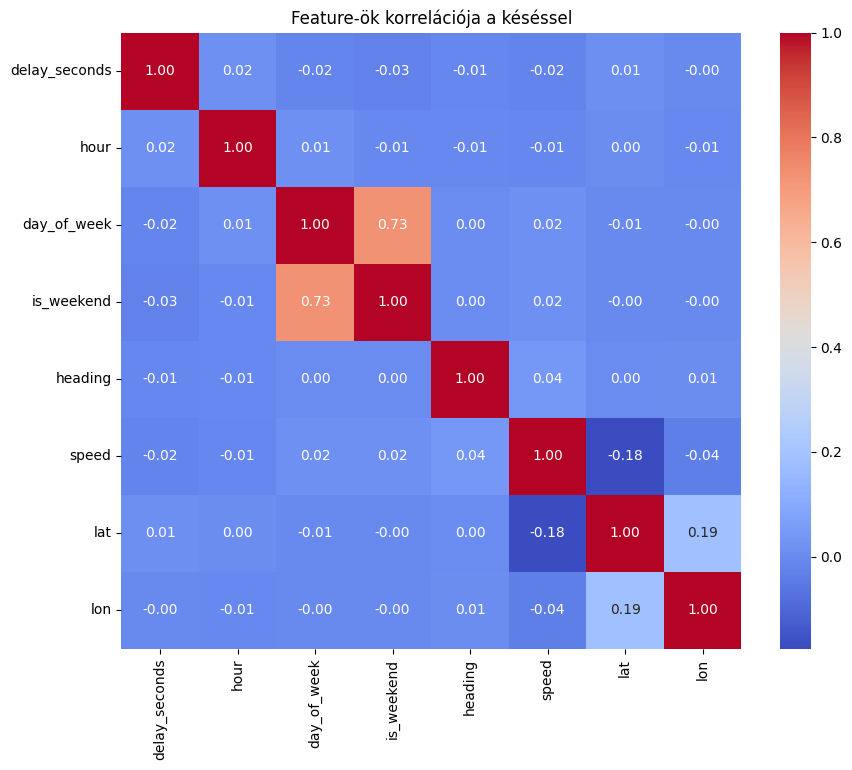

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature-ök korrelációja a késéssel')
plt.show()

In [7]:
data_df['hour_sin'] = np.sin(2 * np.pi * data_df['hour'] / 24)
data_df['hour_cos'] = np.cos(2 * np.pi * data_df['hour'] / 24)

data_df['day_sin'] = np.sin(2 * np.pi * data_df['day_of_week'] / 7)
data_df['day_cos'] = np.cos(2 * np.pi * data_df['day_of_week'] / 7)

In [8]:
data_df = data_df.sort_values(['trip_id', 'timestamp_utc'])
data_df['final_delay'] = data_df.groupby('trip_id')['delay_seconds'].transform('last')

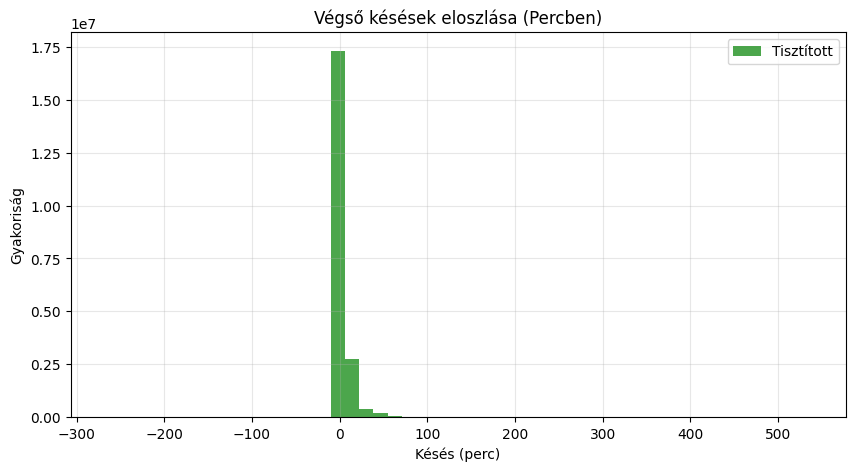

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(data_df['final_delay'] /60, bins=50, color='green', alpha=0.7, label='Tisztított')
plt.title('Végső késések eloszlása (Percben)')
plt.xlabel('Késés (perc)')
plt.ylabel('Gyakoriság')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
features_to_check.extend(['final_delay', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos'])
features_to_check = [f for f in features_to_check if f not in ['hour', 'day_of_week']]
features_to_check

['delay_seconds',
 'is_weekend',
 'heading',
 'speed',
 'lat',
 'lon',
 'final_delay',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos']

Text(0.5, 1.0, 'Feature-ök korrelációja a végső késéssel')

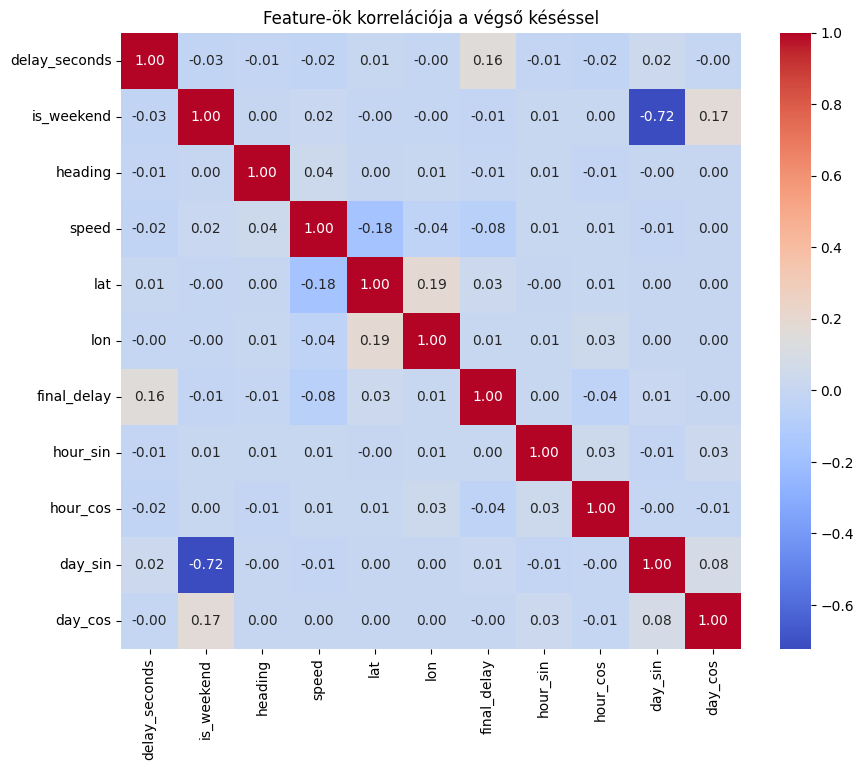

In [23]:
corr_matrix = data_df[features_to_check].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature-ök korrelációja a végső késéssel')

In [11]:
def clean_data(df):
    print(f"Eredeti méret: {len(df):,} sor")

    df = df.drop_duplicates(subset=['trip_id', 'timestamp_utc'])
    df = df[(df['delay_seconds'] > -900) & (df['delay_seconds'] < 7200)]

    if 'lat' in df.columns and 'lon' in df.columns:
        df = df[(df['lat'] > 47.1) & (df['lat'] < 47.7) & 
                (df['lon'] > 18.8) & (df['lon'] < 19.3)]
        
    trip_counts = df['trip_id'].value_counts()
    valid_trips = trip_counts[trip_counts >= 10].index
    df = df[df['trip_id'].isin(valid_trips)]
    
    print(f"Tisztított méret: {len(df):,} sor")
    return df

In [12]:
df_cleaned = clean_data(data_df)


Eredeti méret: 23,736,316 sor
Tisztított méret: 19,531,015 sor


Text(0.5, 1.0, 'Feature-ök korrelációja a tisztítás után')

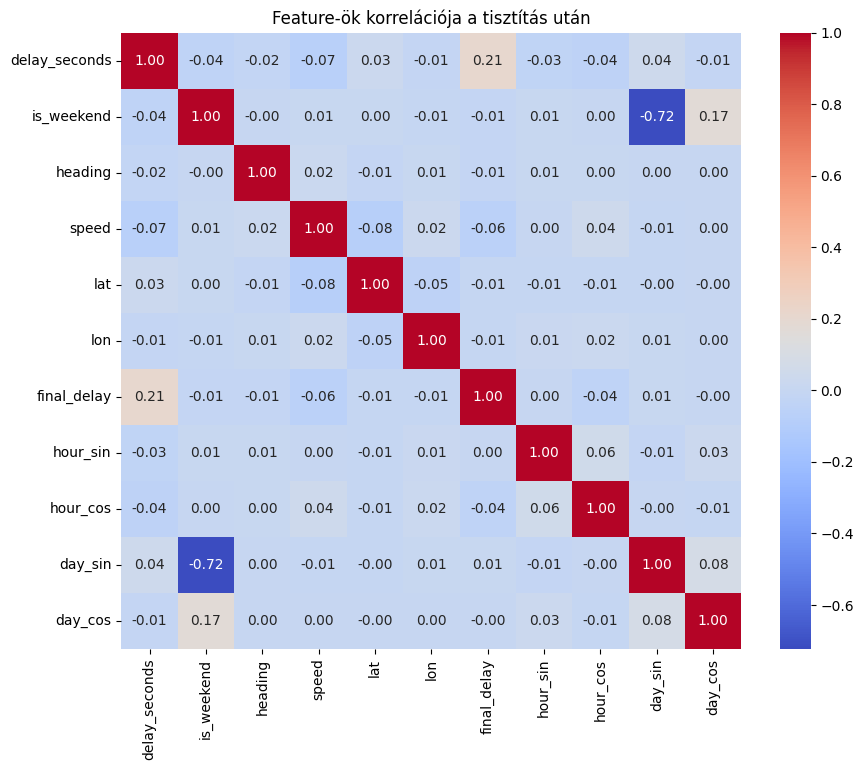

In [37]:
corr_matrix = df_cleaned[features_to_check].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature-ök korrelációja a tisztítás után')

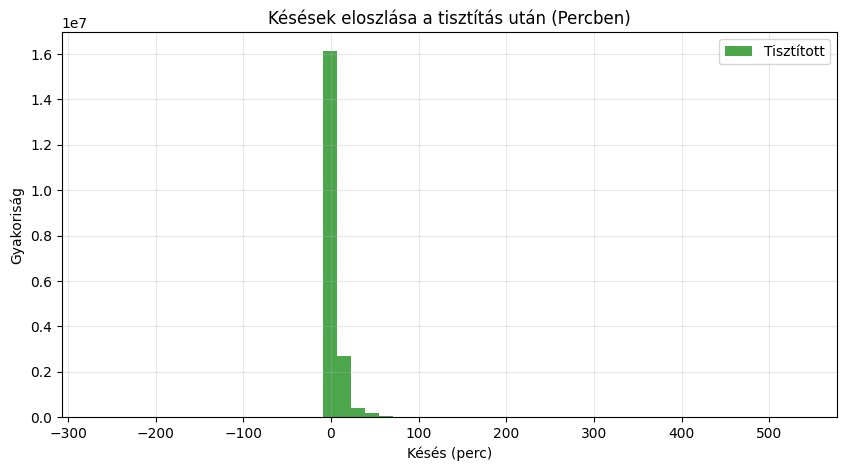

In [51]:
plt.figure(figsize=(10, 5))
plt.hist(df_cleaned['final_delay'] / 60, bins=50, color='green', alpha=0.7, label='Tisztított')
plt.title('Késések eloszlása a tisztítás után (Percben)')
plt.xlabel('Késés (perc)')
plt.ylabel('Gyakoriság')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
data_to_plot = df_cleaned.copy()
plot_df = data_to_plot[data_to_plot['delay_seconds'] != 0].copy()
plot_df['ts_local'] = pd.to_datetime(plot_df['vehicle_timestamp'])
if plot_df['ts_local'].dt.tz is None:
    plot_df['ts_local'] = plot_df['ts_local'].dt.tz_localize('UTC').dt.tz_convert('Europe/Budapest')

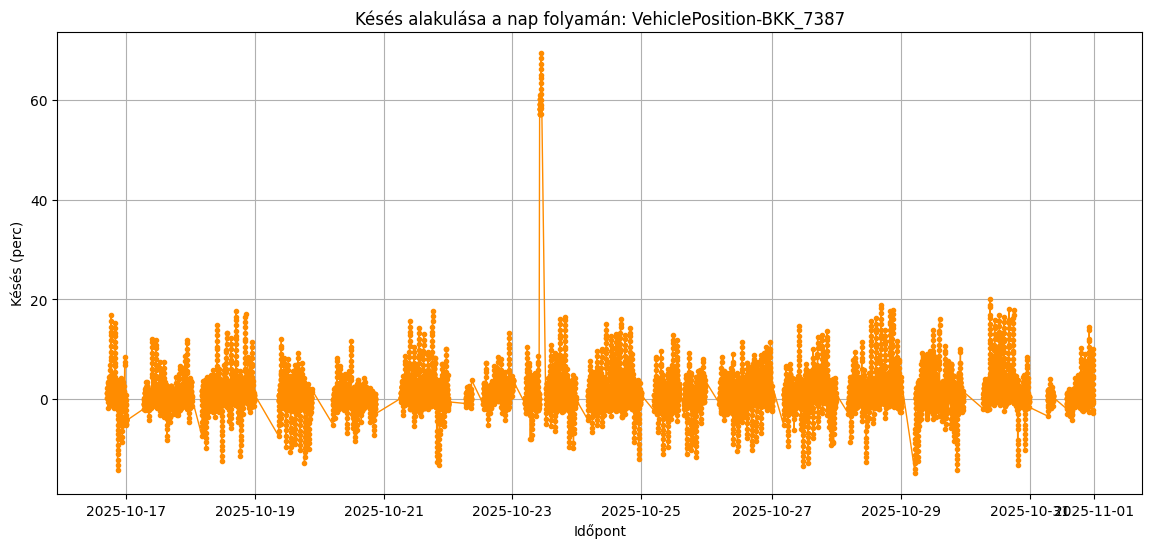

In [34]:
top_vehicle = plot_df['vehicle_id'].value_counts().idxmax()
single_vehicle_data = plot_df[plot_df['vehicle_id'] == top_vehicle].sort_values('ts_local')

plt.figure(figsize=(14, 6))
plt.plot(single_vehicle_data['ts_local'], single_vehicle_data['delay_seconds'] / 60, 
         marker='o', markersize=3, linestyle='-', linewidth=1, color='darkorange')
plt.title(f'Késés alakulása a nap folyamán: {top_vehicle}')
plt.xlabel('Időpont')
plt.ylabel('Késés (perc)')
plt.grid(True)
plt.show()

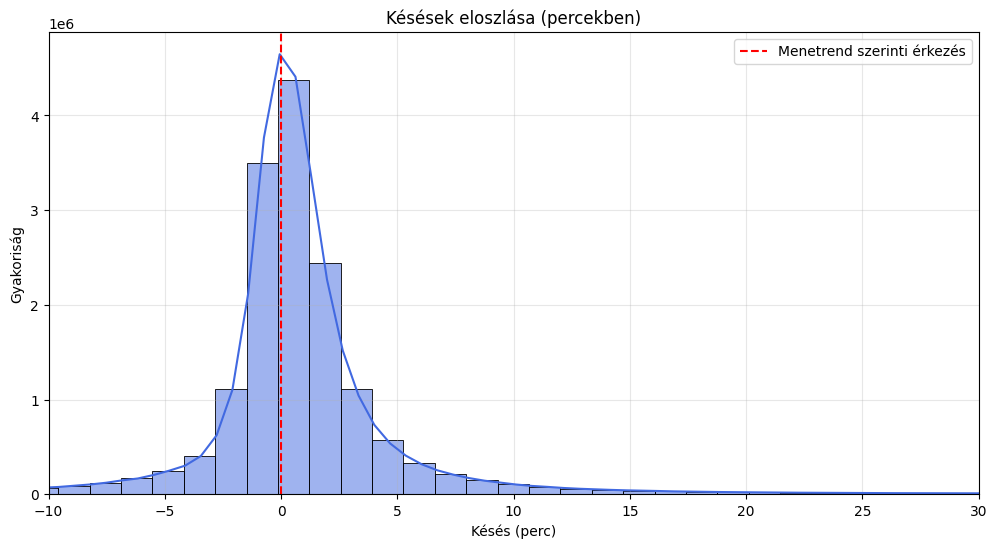

In [35]:
plt.figure(figsize=(12, 6))
# Csak a -10 és +30 perc közötti tartományt nézzük a jobb olvashatóságért
sns.histplot(plot_df['delay_seconds'] / 60, bins=100, kde=True, color='royalblue')
plt.title('Késések eloszlása (percekben)')
plt.xlabel('Késés (perc)')
plt.ylabel('Gyakoriság')
plt.xlim(-10, 30)  # Zoom a lényegre
plt.axvline(0, color='red', linestyle='--', label='Menetrend szerinti érkezés')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\manle\AppData\Local\Temp\ipykernel_15328\3486730069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y=plot_df['delay_seconds'] / 60, data=plot_df, palette="viridis", showfliers=False)


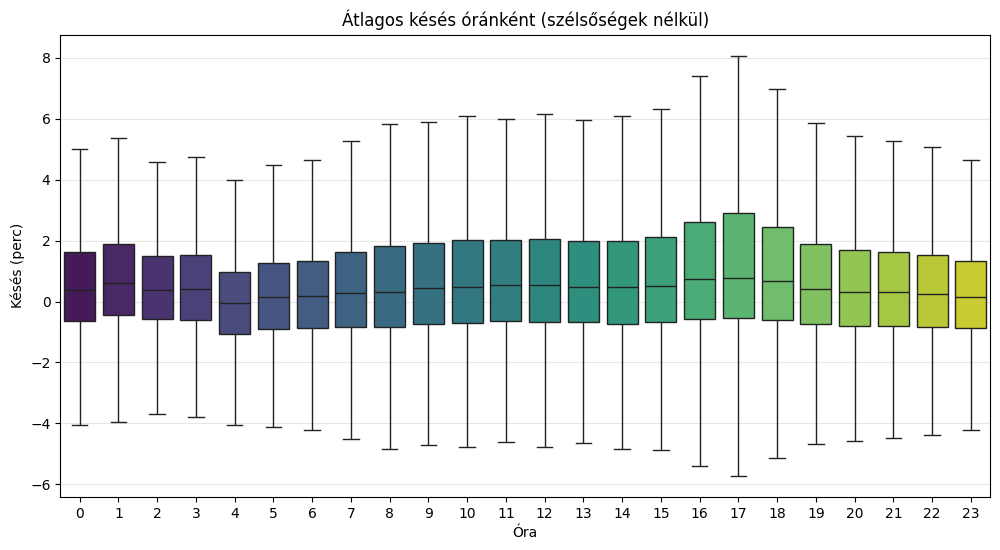

In [36]:
plot_df['hour'] = plot_df['ts_local'].dt.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y=plot_df['delay_seconds'] / 60, data=plot_df, palette="viridis", showfliers=False)
plt.title('Átlagos késés óránként (szélsőségek nélkül)')
plt.xlabel('Óra')
plt.ylabel('Késés (perc)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19531015 entries, 966938 to 11938658
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp_utc          datetime64[ns]
 1   vehicle_id             object        
 2   trip_id                object        
 3   route_id               object        
 4   lat                    float64       
 5   lon                    float64       
 6   speed                  float64       
 7   heading                float64       
 8   vehicle_timestamp      object        
 9   stop_id                object        
 10  current_stop_sequence  int64         
 11  delay_seconds          int64         
 12  hour                   int32         
 13  day_of_week            int32         
 14  is_weekend             bool          
 15  hour_sin               float64       
 16  hour_cos               float64       
 17  day_sin                float64       
 18  day_cos             

In [15]:
FEATURES_TO_KEEP = [
    'trip_id', 
    'timestamp_utc', 
    
    'final_delay',
    
    'delay_seconds',
    'current_stop_sequence',
    'speed',
    'heading',
    'lat',
    'lon',
    
    'hour_sin', 'hour_cos',
    'day_sin', 'day_cos',
    'is_weekend',
    
    'route_id',
    'stop_id'
]
df_final = df_cleaned[FEATURES_TO_KEEP].copy()

In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19531015 entries, 966938 to 11938658
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trip_id                object        
 1   timestamp_utc          datetime64[ns]
 2   final_delay            float64       
 3   delay_seconds          int64         
 4   current_stop_sequence  int64         
 5   speed                  float64       
 6   heading                float64       
 7   lat                    float64       
 8   lon                    float64       
 9   hour_sin               float64       
 10  hour_cos               float64       
 11  day_sin                float64       
 12  day_cos                float64       
 13  is_weekend             bool          
 14  route_id               object        
 15  stop_id                object        
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(3)
memory usage: 2.3+ GB


In [17]:
df_final['is_weekend'] = df_final['is_weekend'].astype(int)

In [18]:
df_final.head()

,trip_id,timestamp_utc,final_delay,delay_seconds,current_stop_sequence,speed,heading,lat,lon,hour_sin,hour_cos,day_sin,day_cos,is_weekend,route_id,stop_id
966938,1403_38,2025-10-17 06:06:54,0.0,0,12,26.666666,308.0,47.458679,19.291910,1.0,6.123234e-17,-0.433884,-0.900969,0,EC,005510017_0
968747,1403_38,2025-10-17 06:07:55,0.0,0,12,26.111111,308.0,47.461609,19.286369,1.0,6.123234e-17,-0.433884,-0.900969,0,EC,005510017_0
970558,1403_38,2025-10-17 06:08:55,0.0,0,12,27.777779,282.0,47.467449,19.254990,1.0,6.123234e-17,-0.433884,-0.900969,0,EC,005510017_0
972368,1403_38,2025-10-17 06:09:56,0.0,0,12,27.222221,298.0,47.470650,19.236191,1.0,6.123234e-17,-0.433884,-0.900969,0,EC,005510017_0
974179,1403_38,2025-10-17 06:10:56,0.0,0,12,27.500000,298.0,47.473701,19.227850,1.0,6.123234e-17,-0.433884,-0.900969,0,EC,005510017_0


In [19]:
df_final = df_final.sort_values('timestamp_utc')

In [20]:
df_final['process_date'] = df_final['timestamp_utc'].dt.date
unique_dates = sorted(df_final['process_date'].unique())

In [21]:
unique_dates

[datetime.date(2025, 10, 16),
 datetime.date(2025, 10, 17),
 datetime.date(2025, 10, 18),
 datetime.date(2025, 10, 19),
 datetime.date(2025, 10, 20),
 datetime.date(2025, 10, 21),
 datetime.date(2025, 10, 22),
 datetime.date(2025, 10, 23),
 datetime.date(2025, 10, 24),
 datetime.date(2025, 10, 25),
 datetime.date(2025, 10, 26),
 datetime.date(2025, 10, 27),
 datetime.date(2025, 10, 28),
 datetime.date(2025, 10, 29),
 datetime.date(2025, 10, 30),
 datetime.date(2025, 10, 31)]

In [22]:
TRAIN_DAYS_COUNT = 10
split_index = TRAIN_DAYS_COUNT

In [23]:
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

In [24]:
train_df = df_final[df_final['process_date'].isin(train_dates)].drop(columns=['process_date'])
test_df = df_final[df_final['process_date'].isin(test_dates)].drop(columns=['process_date'])

In [25]:
EXPORT_TRAIN = '../data/train_data.csv'
EXPORT_TEST = '../data/test_data.csv'

In [27]:
train_df.to_csv(EXPORT_TRAIN, index=False)
test_df.to_csv(EXPORT_TEST, index=False)

In [53]:
EXPORT_PATH = '../data/cleaned_data.csv'
df_final.to_csv(EXPORT_PATH, index=False)